<a href="https://colab.research.google.com/github/ayush111111/unet-fet/blob/main/Unet_fetal_head_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/'Semester Project '/dataset/
%ls


/content/drive/MyDrive/Semester Project /dataset
best_model_224_res.h5  test_set/  training_set/


In [8]:
# import necessary libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

In [9]:
# training data path
trainPath = "training_set/"
file_list_train = sorted(os.listdir(trainPath))

#test data path
path_test = "test_set/"
file_list_test = sorted(os.listdir(path_test))

In [10]:
train_image = []
train_mask = []
for idx, item in enumerate(file_list_train):
    if idx % 2 == 0:
        train_image.append(item)
    else:
        train_mask.append(item)
print("Number of US training images is {}".format(len(train_image)))
print("Number of US training masks is {}".format(len(train_mask)))  
print(train_image[:5],"\n" ,train_mask[:5])

Number of US training images is 999
Number of US training masks is 999
['000_HC.png', '001_HC.png', '002_HC.png', '003_HC.png', '004_HC.png'] 
 ['000_HC_Annotation.png', '001_HC_Annotation.png', '002_HC_Annotation.png', '003_HC_Annotation.png', '004_HC_Annotation.png']


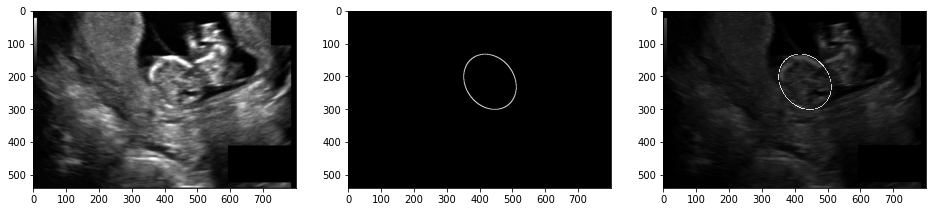

In [11]:


# Display the first image and mask of the first subject.
image1 = np.array(Image.open(trainPath+"009_HC.png"))
image1_mask = np.array(Image.open(trainPath+"009_HC_Annotation.png"))
# binary inverse the mask
# image1_mask = np.ma.masked_where(image1_mask!=0, image1_mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(image1, cmap = 'gray')

ax[1].imshow(image1_mask, cmap = 'gray')

ax[2].imshow(image1, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, cmap = 'gray', interpolation = 'none', alpha = 0.7)


Note the images in this dataset are not of the same shape.

In [12]:


## Storing data
X = []
y = []
for image, mask in zip(train_image, train_mask):
    X.append(np.array(Image.open(trainPath+image)))
    y.append(np.array(Image.open(trainPath+mask)))

X = np.array(X)
y = np.array(y)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)



X_shape :  (999,)
y_shape :  (999,)


<ipython-input-12-cd082fb8a4f6>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-12-cd082fb8a4f6>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [13]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# set target image size
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [16]:
smooth = 1.
# define loss function and metrics
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
# define building blocks
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [ ]:
# Build U-Net model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [ ]:
def Generator(X_list, y_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = X_list[i]
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask =  y_list[i]
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            y[i - c] = mask
        
        X = X[:,:,:,np.newaxis] / 255
        y = y[:,:,:,np.newaxis] / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X, y

In [ ]:
train_img_aug = []
train_mask_aug = []

def augmentation(imgs, masks): 
    for img, mask in zip(imgs, masks):
        img = cv2.imread(trainPath + img)
        mask = cv2.imread(trainPath + mask)
        train_img_aug.append(img)
        
        train_mask_aug.append(mask)
        img_lr = np.fliplr(img)
        mask_lr = np.fliplr(mask)

        img_up = np.flipud(img)
        mask_up = np.flipud(mask)

        img_lr_up = np.flipud(img_lr)
        mask_lr_up = np.flipud(mask_lr)

        img_up_lr = np.fliplr(img_up)
        mask_up_lr = np.fliplr(mask_up)

        train_img_aug.append(img_lr)
        train_mask_aug.append(mask_lr)

        train_img_aug.append(img_up)
        train_mask_aug.append(mask_up)

        train_img_aug.append(img_lr_up)
        train_mask_aug.append(mask_lr_up)

        train_img_aug.append(img_up_lr)
        train_mask_aug.append(mask_up_lr)



In [ ]:
augmentation(train_image, train_mask)
print(len(train_image))
print(len(train_img_aug))

999
4995


In [ ]:


#split training data
X_train, X_val, y_train, y_val = train_test_split(train_img_aug, train_mask_aug, test_size = 0.3, random_state = 1)

# set training parameters
epochs = 50
batch_size = 16
steps_per_epoch = int(len(X_train) / batch_size)
validation_steps = int(len(X_val) / batch_size)

train_gen = Generator(X_train, y_train, batch_size = batch_size)
val_gen = Generator(X_val, y_val, batch_size = batch_size)

# initialize our model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
output_layer = build_model(inputs, 16, 0.5)

# Define callbacks to save model with best val_dice_coef
checkpointer = ModelCheckpoint(filepath = 'best_model_224_res.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
model = Model(inputs=[inputs], outputs=[output_layer])
model.compile(optimizer=Adam(lr = 3e-5), loss=dice_coef_loss, metrics=[dice_coef])



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:


results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs,
                             validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer])



<ipython-input-17-989b9384d0e2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs,


Epoch 1/50
218/218 [==============================] - ETA: 0s - loss: -0.0246 - dice_coef: 0.0246
Epoch 1: val_dice_coef improved from -inf to 0.01790, saving model to best_model_224_res.h5
218/218 [==============================] - 102s 400ms/step - loss: -0.0246 - dice_coef: 0.0246 - val_loss: -0.0179 - val_dice_coef: 0.0179
Epoch 2/50
218/218 [==============================] - ETA: 0s - loss: -0.0344 - dice_coef: 0.0344
Epoch 2: val_dice_coef improved from 0.01790 to 0.03292, saving model to best_model_224_res.h5
218/218 [==============================] - 87s 399ms/step - loss: -0.0344 - dice_coef: 0.0344 - val_loss: -0.0329 - val_dice_coef: 0.0329
Epoch 3/50
218/218 [==============================] - ETA: 0s - loss: -0.0442 - dice_coef: 0.0442
Epoch 3: val_dice_coef improved from 0.03292 to 0.04575, saving model to best_model_224_res.h5
218/218 [==============================] - 84s 384ms/step - loss: -0.0442 - dice_coef: 0.0442 - val_loss: -0.0458 - val_dice_coef: 0.0458
Epoch 4/5

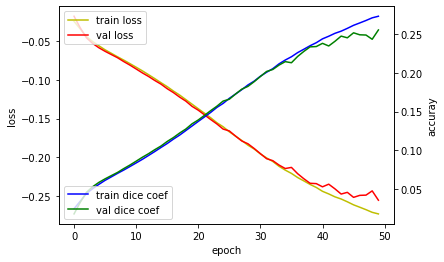

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [6]:

# import os
test_list = os.listdir("test_set/")
print("The number of test data : ", len(test_list))
test_list[:5]



The number of test data :  335


['000_HC.png', '001_HC.png', '004_HC.png', '007_HC.png', '006_HC.png']

In [20]:
#used just for prediction, not as a checkpoint
model = tf.keras.models.load_model('best_model_224_res.h5', compile=False)

In [21]:


X_test = np.empty((len(test_list), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
for i, item in enumerate(test_list):
    image = cv2.imread("test_set/" + item, 0)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    X_test[i] = image
X_test = X_test[:,:,:,np.newaxis] / 255

y_pred = model.predict(X_test)



11/11 [==============================] - 11s 224ms/step


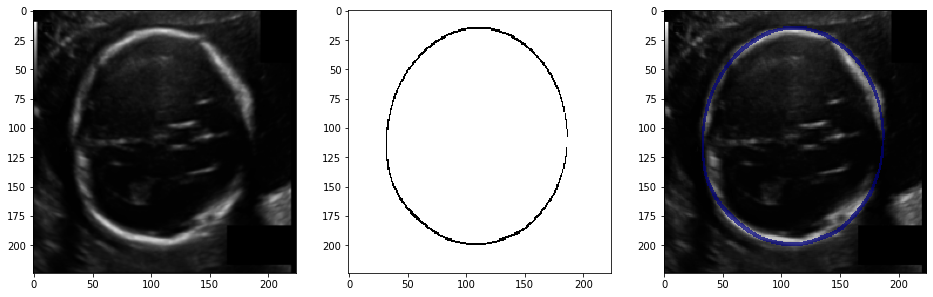

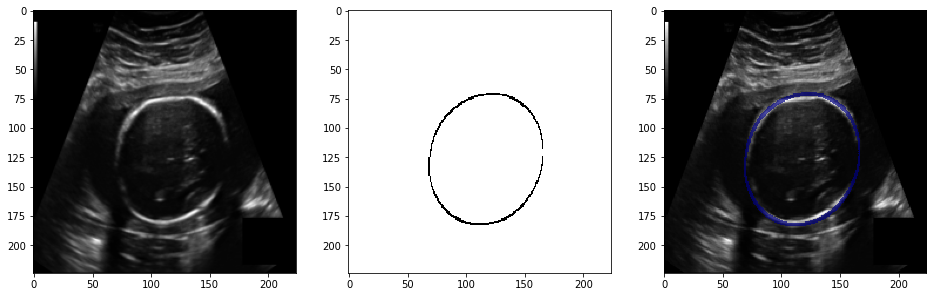

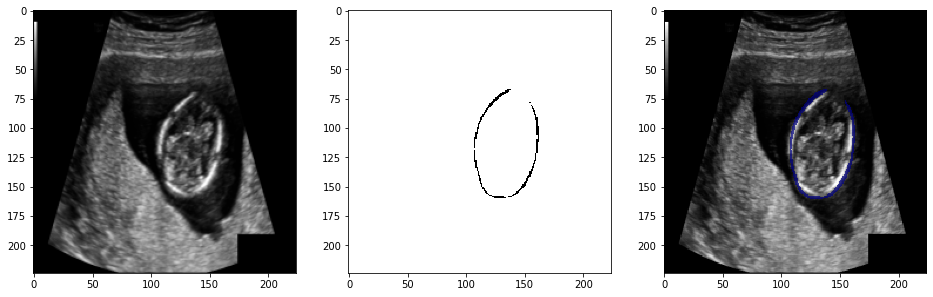

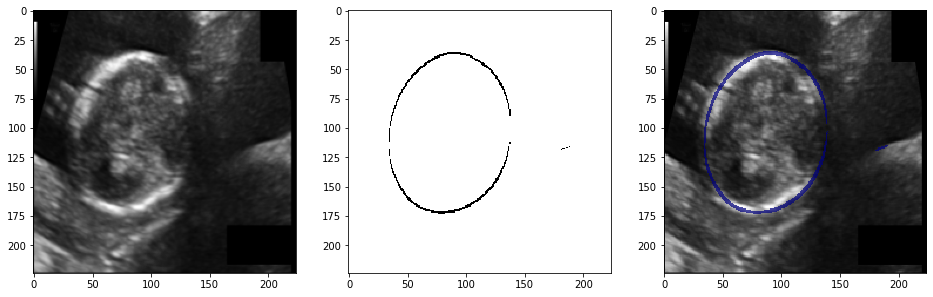

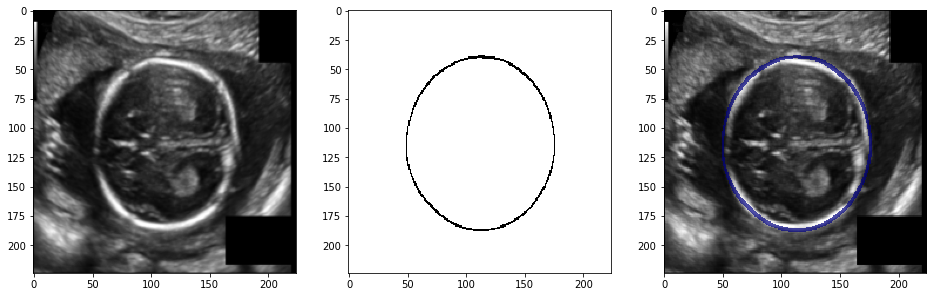

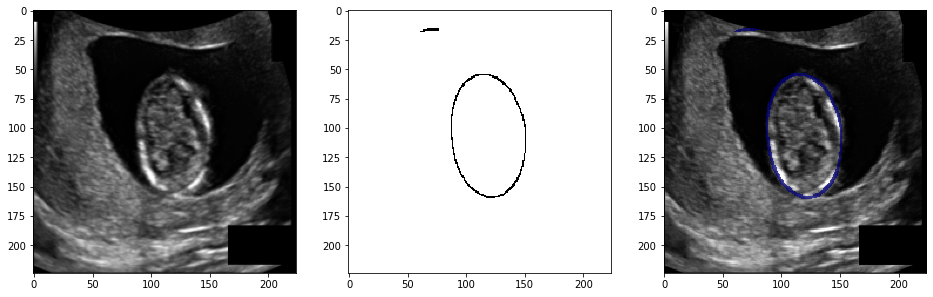

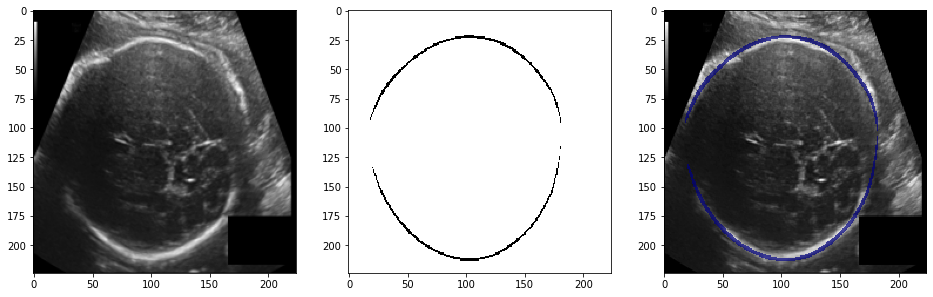

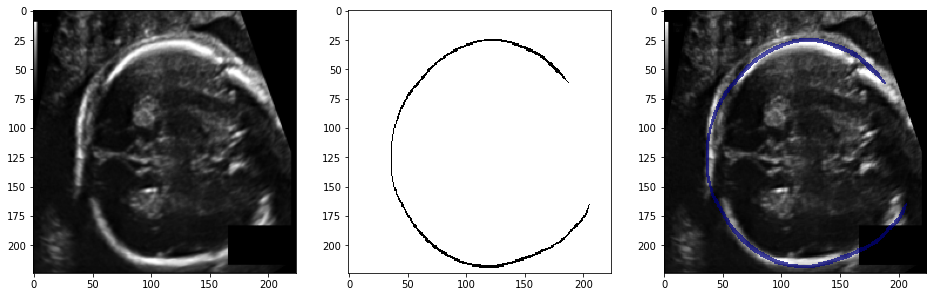

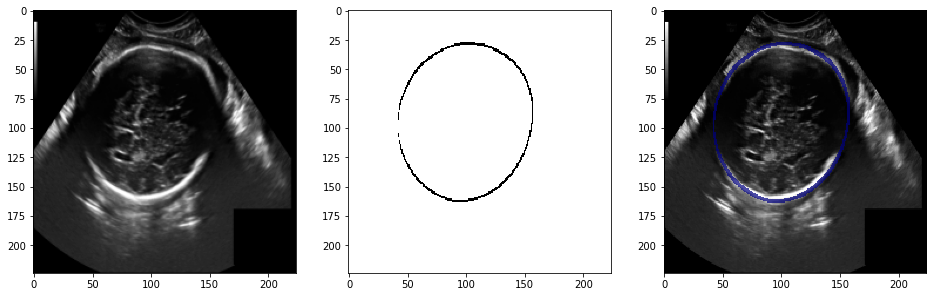

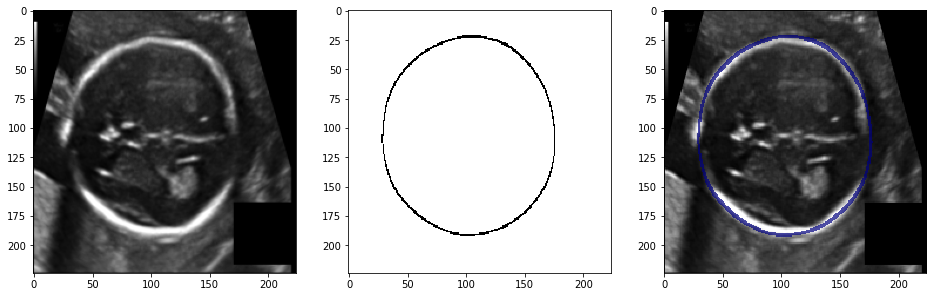

In [22]:
for test, pred in zip(X_test[180:190],y_pred[180:190]):
    fig, ax = plt.subplots(1,3,figsize = (16,12))
    test = test.reshape((IMG_HEIGHT,IMG_WIDTH))

    pred = pred.reshape((IMG_HEIGHT,IMG_WIDTH))
    pred = pred>0.5
    pred = np.ma.masked_where(pred == 0, pred)
    ax[0].imshow(test, cmap = 'gray')

    ax[1].imshow(pred, cmap = 'gray')

    ax[2].imshow(test, cmap = 'gray', interpolation = 'none')
    ax[2].imshow(pred, cmap = 'jet', interpolation = 'none', alpha = 0.7)